In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import pandas as pd

In [110]:
rho_g_per_cm3 = 1.255184 #g/cm^3, 6M KOH
density = rho_g_per_cm3*1000 #kg/m^3
g = 9.81 #m/s^2
gamma = density*g #N/m^3

#### Reynolds Number Calculation for Noncircular Ducts

The Reynolds number is calculated using the hydraulic diameter, $D_h = 4A/P$ $[m]$, average linear velocity, $v$ $[m/s]$, and kinematic viscosity, $\nu$ $[m^2/s]$.

\begin{equation}
Re_h = \frac{D_hv}{\nu}
\end{equation}

In [52]:
def calculate_reynolds(reactor_width, cat_length):
    '''
    takes in the length of the cathode [m], assuming a flat square cathode,
    and the reactor width[m], and calculates Re for a square duct
    '''
    #D_h = 4A/P
    hydraulic_diameter = 4*cat_length*reactor_width / (2*cat_length + 2*reactor_width)
    linear_velocity = 0.13263 #m/s
    kinematic_viscosity_cm = 0.0149 #cm^2/s
    kinematic_viscosity = kinematic_viscosity_cm/(100**2) #m^2/s
    
    Re = hydraulic_diameter*linear_velocity/kinematic_viscosity
    
    ratio = cat_length/reactor_width
#     print('Aspect ratio is {:.2f}'.format(ratio))
#     print(reactor_width)
    return Re, ratio

(2500, 2)


(0.3310810810810811, 0.01, 1337.4605662112901, 1762.6420360156824)

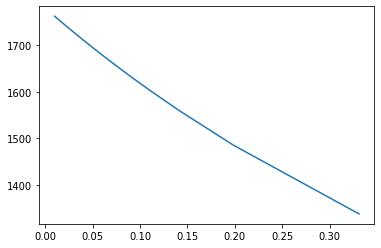

In [92]:
widths = np.linspace(0.01, 1) #range of values from 1cm to 1m
# heights = np.ones_like(widths)
heights = np.linspace(0.01, 1)

geometries = np.array(np.meshgrid(heights,widths)).T.reshape(-1,2)
reynolds = np.zeros_like(geometries[:,0])
ratios = np.zeros_like(geometries[:,0])
print(np.shape(geometries))

#reynolds = array of reynolds #s 
for i in range(len(geometries)):
    reynolds[i], ratios[i] = calculate_reynolds(geometries[i,0],geometries[i,1])

lam_re = []
lam_ratios = []
for i in range(len(reynolds)):
    if reynolds[i] < 2300 and ratios[i]<1: #laminar
        lam_re.append(reynolds[i])
        lam_ratios.append(ratios[i])
#         print(ratios[i])
lam_re

plt.plot(lam_ratios,lam_re)
max(lam_ratios), min(lam_ratios), min(lam_re), max(lam_re)

### Calculating the pressure drop in a noncircular duct

For laminar flow in a noncircular duct:
\begin{equation}
f = \frac{C}{\text{Re}_h}
\end{equation}

head loss, $h_L$, can be calculated by:
\begin{equation}
h_L = f\frac{l}{D_h}\frac{V^2}{2g}
\end{equation}

Then the pressure drop can be found by: 
\begin{equation}
\Delta p = \gamma  h_L
\end{equation}

<img src="Calculate_C.png" alt="Drawing" style="width: 800px;"/>


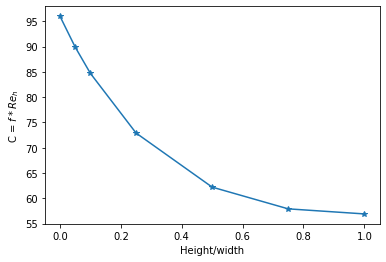

In [93]:
ratios = [0,0.05,0.1,0.25,0.5,0.75,1.0]
Cs = [96.0,89.9,84.7,72.9,62.2,57.9,56.9]
plt.plot(ratios,Cs,'-*')
plt.xlabel('Height/width')
plt.ylabel('C = $f*Re_h$')
plt.show()

In [97]:
#interpolating tabulated data 
def find_C(ratio):
    ratios = [0,0.05,0.1,0.25,0.5,0.75,1.0]
    Cs = [96.0,89.9,84.7,72.9,62.2,57.9,56.9]
    return np.interp(ratio,ratios,Cs)

find_C(.3)

70.76

In [98]:
def pressure_drop(h,w):
    
    L = h #square catalyst as side
    hydraulic_diameter = 4*h*w/(2*h+2*w)
    linear_velocity = 0.13263 #m/s
    kinematic_viscosity_cm = 0.0149 #cm^2/s
    kinematic_viscosity = kinematic_viscosity_cm/(100**2)
    
    Re_h = hydraulic_diameter*linear_velocity/kinematic_viscosity
    ratio = h/w #or vice versa? 
    
    C = find_C(ratio)
    f = C/Re_h
    
    head_loss = f*L/hydraulic_diameter*linear_velocity**2/(2*g)
    pressure_drop = gamma*head_loss
     
    return pressure_drop, head_loss #N/m^2

In [130]:
final_height,final_width = 1, .01

pd, head = pressure_drop(final_height,final_width)
p_bar = 1e-5*pd
print('Pressure drop: {:.2e} bar'.format(p_bar))

Pressure drop: 1.80e-04 bar


### Calculating Pump Power

source: https://www.aiche.org/resources/publications/cep/2016/december/pump-sizing-bridging-gap-between-theory-and-practice

\begin{equation}
P = \frac{Q \rho g H}{3.6x10^6 \eta}
\end{equation}

where P is the pump power (kW), Q is the flowrate (m3/hr), H is the total pump head (m of fluid), and η is the pump efficiency (if you do not know the efficiency, use η = 0.7). 

In [128]:
#flowrate = hw*linear_velocity
h = final_height
w = final_width
linear_velocity = 0.13263 #m/s
Q = h*w*linear_velocity #m^3/s
Q_hr = 3600*Q
pump_efficiency = 0.7 #AichE Paper said to use this if we don't know

Power = Q_hr*density*g*head/(pump_efficiency*3.6e6) #kW
Power

# print(Q*60)
print('Pump power = {:.2e} kW'.format(Power)) #kW
print('Note: This is only based on the pressure drop across 1 cell. \nConsider adding considerations for piping, fittings, geometry change.')

Pump power = 3.41e-05 kW
Note: This is only based on the pressure drop across 1 cell. 
Consider adding considerations for piping, fittings, geometry change.


### Calculating Pump power for a given width [m]

In [131]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [156]:
def POWER(w):
    
    h = 1
    L = h #square catalyst as side
    hydraulic_diameter = 4*h*w/(2*h+2*w)
    linear_velocity = 0.13263 #m/s
    kinematic_viscosity_cm = 0.0149 #cm^2/s
    kinematic_viscosity = kinematic_viscosity_cm/(100**2)
    
    Re_h = hydraulic_diameter*linear_velocity/kinematic_viscosity
    ratio = h/w  
    
    C = find_C(ratio)
    f = C/Re_h
    
    head_loss = f*L/hydraulic_diameter*linear_velocity**2/(2*g)
    pressure_drop = gamma*head_loss
    linear_velocity = 0.13263 #m/s
    
    Q = h*w*linear_velocity #m^3/s
    Q_hr = 3600*Q
    pump_efficiency = 0.7 #AichE Paper said to use this if we don't know

    Power = Q_hr*density*g*head/(pump_efficiency*3.6e6) #kW
     
    return Power #kW

#pass 'interact' the function and then the variable name u will change
#=(min,max,step)
interact(POWER,w=(.005,.5)) #kW for widths from .5cm to 50cm

interactive(children=(FloatSlider(value=0.2525, description='w', max=0.5, min=0.005), Output()), _dom_classes=…

<function __main__.POWER(w)>

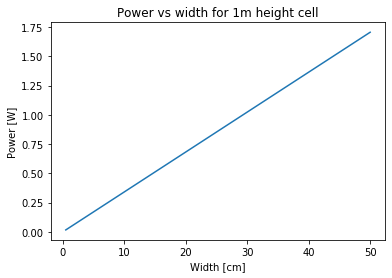

In [149]:
ws = np.linspace(.005,.5) #0.5 to 50cm
powers = POWER(ws)
plt.plot(ws*100,powers*1000)
plt.xlabel('Width [cm]')
plt.ylabel('Power [W]')
plt.title('Power vs width for 1m height cell')
plt.show()

In [155]:
from scipy.stats import linregress
ans = linregress(ws*100,powers*1000) 
slope = ans[0] #W/cm
slope

0.03409919992738097